In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Fetch historical data for Google stock (GOOG)
df = yf.download('GOOG', start='2010-01-01', end='2024-12-01')

# Display the first few rows of the data
print(df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG
Date                                                             
2010-01-04  15.517998  15.586333  15.455851  15.522949   78541293
2010-01-05  15.449662  15.544986  15.389001  15.528644  120638494
2010-01-06  15.060195  15.495961  15.013152  15.495961  159744526
2010-01-07  14.709601  15.103277  14.673700  15.088422  257533695
2010-01-08  14.905695  14.936149  14.586050  14.657605  189680313


# reshaping the data

In [ ]:
# converted my data to a 2d array with n rows and 1 column... thats what the reshape(-1,1) actually did
# .values converts to numpy array
print("Shape of df = ", df.shape, "\n")
print("Shape of df['Close'] = ", df['Close'].shape)
data = df['Close'].values.reshape(-1,1)
print("\ndata shape = ", data.shape, "\n")
data



Shape of df =  (3753, 5) 

Shape of df['Close'] =  (3753, 1)

data shape =  (3753, 1) 



array([[ 15.51799774],
       [ 15.44966221],
       [ 15.06019497],
       ...,
       [170.02833557],
       [170.22764587],
       [169.89878845]])

# Preprocessing

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data


array([[0.02609189],
       [0.02571423],
       [0.02356179],
       ...,
       [0.88001071],
       [0.88111222],
       [0.87929475]])

In [ ]:
scaled_data.shape

(3753, 1)

# Splitting into training and testing

In [ ]:
scale_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:scale_size]
test_data = scaled_data[scale_size:]

In [ ]:
print(train_data.shape)
print(test_data.shape)
print(len(data))

(3002, 1)
(751, 1)
3753


In [ ]:
def create_sequences(data, sequence_len):
  x = []
  y = []

  for i in range(len(data) - sequence_len):
    x.append(data[i:i+sequence_len])
    y.append(data[i+sequence_len])

  #convert to numpy array
  return np.array(x), np.array(y)

sequence_len = 60
xtrain, ytrain = create_sequences(train_data, sequence_len)
xtest, ytest = create_sequences(test_data, sequence_len)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(2942, 60, 1)
(2942, 1)
(691, 60, 1)
(691, 1)


In [ ]:
xtrain[0].shape



(60, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Bidirectional,Dropout

regressor = Sequential()

# Add Bidirectional GRU layer (replacing LSTM)
regressor.add(LSTM(units=70, return_sequences=False , input_shape=(xtrain.shape[1], 1)))

# Add Dense layers
regressor.add(Dense(units=1))

# Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
print(regressor.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 70)             │        20,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,231 (79.03 KB)

 Trainable params: 20,231 (79.03 KB)

 Non-trainable params: 0 (0.00 B)

None


##### LSTM MODEL

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=15)

regressor.fit(xtrain, ytrain, epochs = 100, validation_data =(xtest, ytest), batch_size = 32, callbacks=[early_stop])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0117 - val_loss: 9.9209e-04
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.9165e-05 - val_loss: 7.6103e-04
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9869e-05 - val_loss: 8.7913e-04
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.7109e-05 - val_loss: 7.2438e-04
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6680e-05 - val_loss: 7.8684e-04
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.1554e-05 - val_loss: 6.8801e-04
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3335e-05 - val_loss: 6.8827e-04
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7802e-05 - val_loss: 7.4622e-04
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.8542e-05 - val_loss: 6.7867e-04
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3510e-05 - val_loss: 9.0957e-04
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9317e-05 -

In [ ]:
predictions = regressor.predict(xtest)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
predictions.shape

(691, 1)

In [ ]:
ytest.shape

(691, 1)

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest.shape

(691, 1)

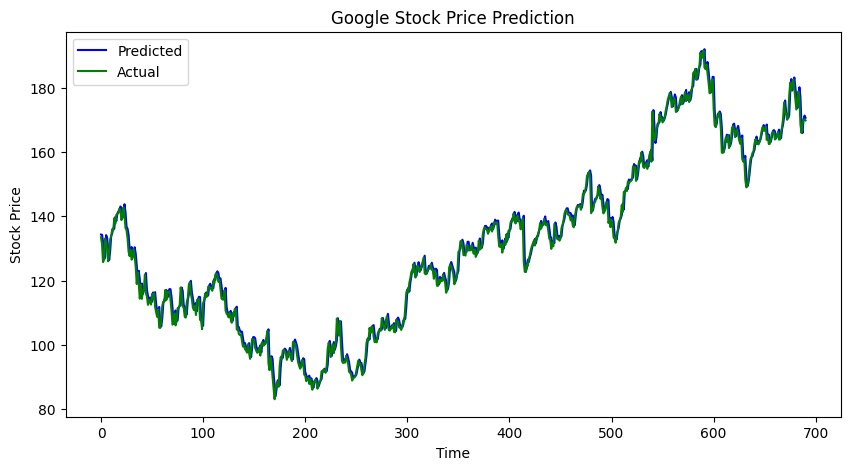

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(predictions, label='Predicted', color='blue')
plt.plot(ytest, label='Actual', color='green')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
ytest[:5]

array([[133.51438904],
       [131.34127808],
       [125.71722412],
       [126.52641296],
       [133.07498169]])

In [ ]:
predictions[:5]



array([[134.31828 ],
       [134.23192 ],
       [132.13489 ],
       [126.59372 ],
       [127.181816]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae = mean_absolute_error(ytest, predictions)

# Mean Squared Error
mse = mean_squared_error(ytest, predictions)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R-squared Score
r2 = r2_score(ytest, predictions)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((ytest - predictions) / ytest)) * 100


# Print all metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 1.9220
MSE: 6.9367
RMSE: 2.6338
R² Score: 0.9905
MAPE: 1.54%


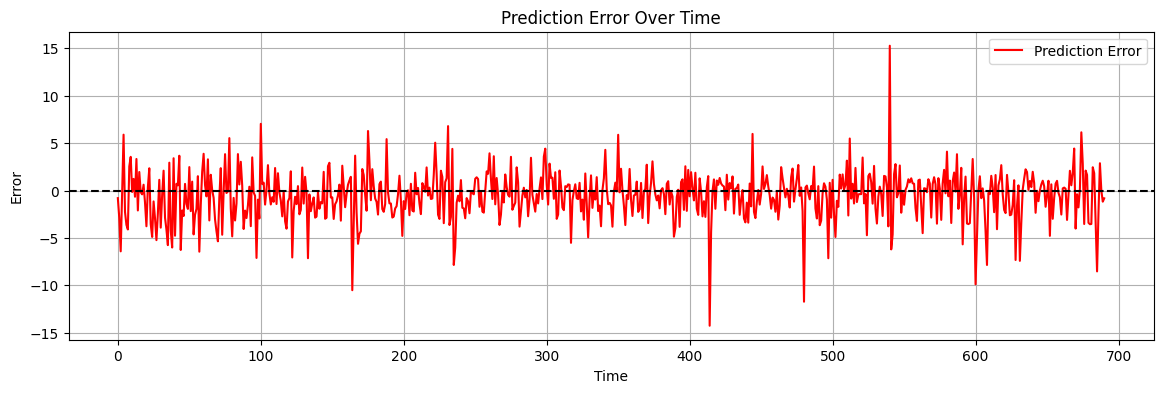

In [ ]:
error = ytest - predictions

plt.figure(figsize=(14, 4))
plt.plot(error, label='Prediction Error', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()



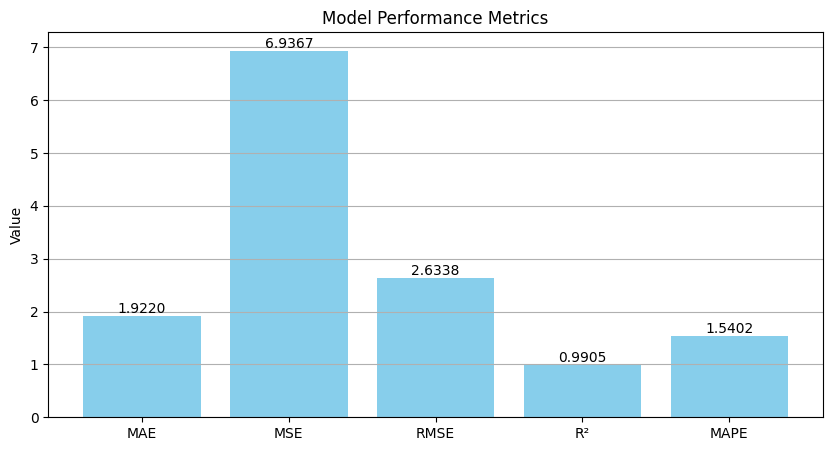

In [ ]:
import numpy as np

metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
values = [mae, mse, rmse, r2, mape]

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, values, color='skyblue')
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.grid(axis='y')

# Optional: Add values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()


In [ ]:
scaled_data.shape

(3753, 1)

In [ ]:
print(scaled_data[-60:].shape)
print(len(scaled_data[-60:]))

(60, 1)
60


In [ ]:
last_sequence = scaled_data[-60:]
last_sequence = last_sequence.reshape(1,60,1)
last_prediction = regressor.predict(last_sequence)
last_prediction = scaler.inverse_transform(last_prediction)
print("Last Prediction:", last_prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Last Prediction: 170.04129


# Now use the RNN model and compare it with the LSTM used previously

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Fetch historical data for Google stock (GOOG)
df = yf.download('GOOG', start='2010-01-01', end='2024-12-01')

# Display the first few rows of the data
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG
Date                                                             
2010-01-04  15.517998  15.586333  15.455851  15.522949   78541293
2010-01-05  15.449662  15.544986  15.389001  15.528644  120638494
2010-01-06  15.060195  15.495961  15.013152  15.495961  159744526
2010-01-07  14.709601  15.103277  14.673700  15.088422  257533695
2010-01-08  14.905695  14.936149  14.586050  14.657605  189680313


In [ ]:
data = df['Close'].values.reshape(-1,1)
data

array([[ 15.51799774],
       [ 15.44966221],
       [ 15.06019497],
       ...,
       [170.02833557],
       [170.22764587],
       [169.89878845]])

In [ ]:
data.shape

(3753, 1)

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape

(3753, 1)

In [ ]:
test_size = int(len(scaled_data)*0.8)
xtrain = scaled_data[:test_size]
xtest = scaled_data[test_size:]

In [ ]:
print(xtrain.shape)
print(xtest.shape)

(3002, 1)
(751, 1)


In [ ]:
def create_sequences(data, sequence_len):
  x = []
  y = []

  for i in range(len(data) - sequence_len):
    data[i:i+sequence_len]
    x.append(data[i:i+sequence_len])
    y.append(data[i+sequence_len])

  return np.array(x), np.array(y)


sequence_len = 60
xtrain, ytrain = create_sequences(xtrain, sequence_len)
xtest, ytest = create_sequences(xtest, sequence_len)

In [ ]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(2942, 60, 1)
(2942, 1)
(691, 60, 1)
(691, 1)


In [ ]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential()
model.add(SimpleRNN(70, return_sequences = False, input_shape = (sequence_len,1)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 70)             │         5,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,111 (19.96 KB)

 Trainable params: 5,111 (19.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=15)

history = model.fit(xtrain, ytrain, epochs = 100, batch_size = 32, validation_data = (xtest, ytest), callbacks = [early_stop])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0019 - val_loss: 9.4086e-04
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.8126e-05 - val_loss: 9.7517e-04
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3655e-05 - val_loss: 6.1923e-04
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5667e-05 - val_loss: 5.4498e-04
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7350e-05 - val_loss: 5.3942e-04
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.2740e-05 - val_loss: 5.4210e-04
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4475e-05 - val_loss: 4.5635e-04
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1706e-05 - val_loss: 5.2732e-04
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.3969e-05 - val_loss: 4.3595e-04
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.1324e-05 - val_loss: 4.5060e-04
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7991e-05 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


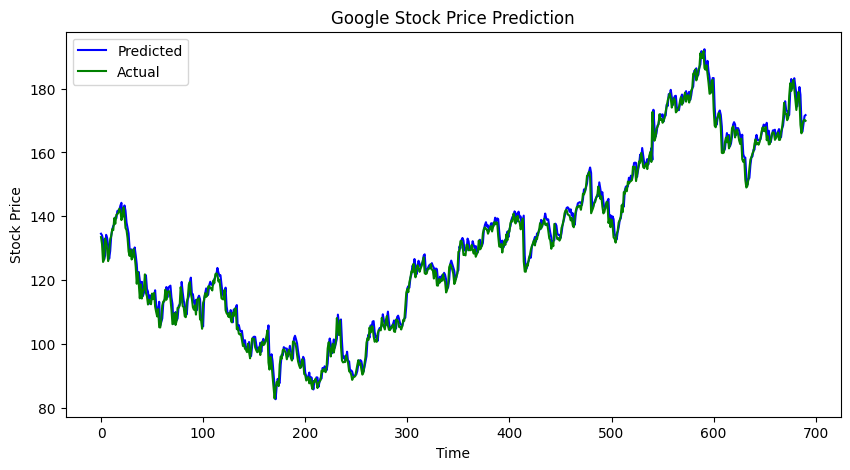

In [ ]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)
ytest = scaler.inverse_transform(ytest)

plt.figure(figsize= (10,5))
plt.plot(predictions, color='blue', label='Predicted')
plt.plot(ytest, color='green', label='Actual')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mean Absolute Error
mae = mean_absolute_error(ytest, predictions)

# Mean Squared Error
mse = mean_squared_error(ytest, predictions)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R-squared Score
r2 = r2_score(ytest, predictions)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((ytest - predictions) / ytest)) * 100


# Print all metrics
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

MAE: 2.0339
MSE: 7.6520
RMSE: 2.7662
R² Score: 0.9896
MAPE: 1.63%


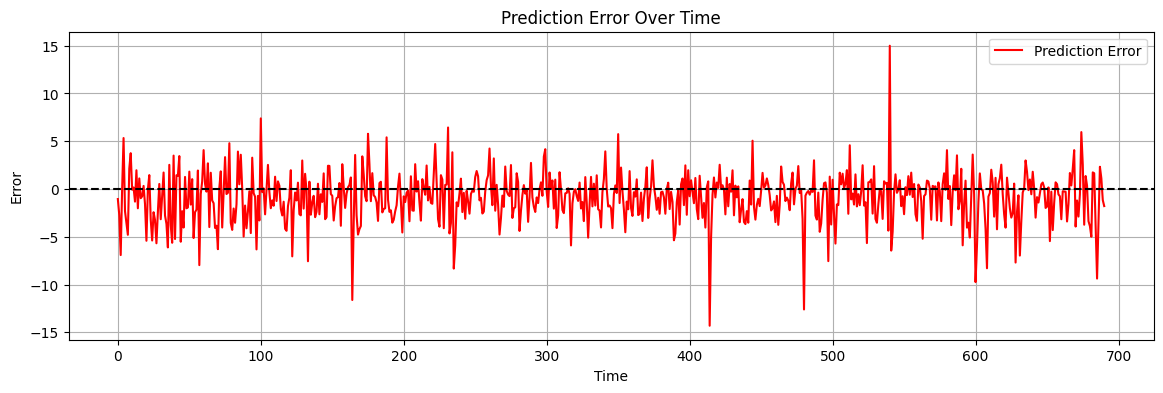

In [ ]:
error = ytest - predictions

plt.figure(figsize=(14, 4))
plt.plot(error, label='Prediction Error', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()


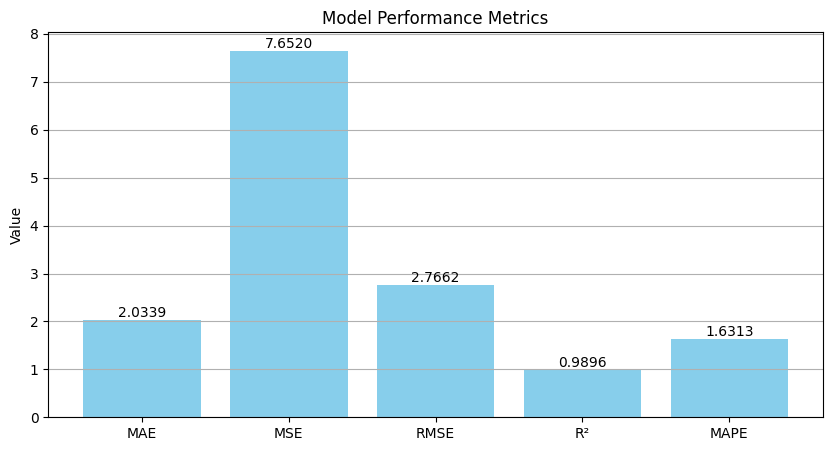

In [ ]:
import numpy as np

metrics = ['MAE', 'MSE', 'RMSE', 'R²', 'MAPE']
values = [mae, mse, rmse, r2, mape]

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, values, color='skyblue')
plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.grid(axis='y')

# Optional: Add values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')

plt.show()


In [ ]:
last_sequence = scaled_data[-sequence_len:]
last_sequence = last_sequence.reshape(1,sequence_len,1)
last_prediction = model.predict(last_sequence)
last_prediction = scaler.inverse_transform(last_prediction)
print("Last Prediction:", last_prediction[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Last Prediction: 170.89671
